In [6]:
import model
import numpy as np
import random
import tank
import truck


import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import utilsq as ut

import time

## System initializer

In [15]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 100., 200., 300., 400.])
    #tank_current_loads =  np.array([50., 60., 120., 150., 300.])
    #tank_current_loads = tank_max_loads.copy()
    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])

        
    for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
        a = np.linspace(0,max_load, lvl+1)[1]
        current_load = np.random.randint(a+1,max_load)
        tank_current_loads[i] = current_load  

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([20., 50.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    #w =  np.array([0, 20., 10., 30., 50.5, 45.])
    w =  np.array([20., 20., 20., 20., 20., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#print(toy_system.weights)

a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [26]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
#print([load for load in system.tank_loads])

[76, 39, 156, 146, 288]


In [38]:
print(system.tank_loads())
def reinitialize_system(system):
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.randint(a+1,b)
        tank.load = current_load  
        
reinitialize_system(system)
print(system.tank_loads())


[87, 76, 158, 130, 344]
[89, 28, 101, 210, 121]


## Q-learning algorithm (off-policy)


### Training

In [30]:
# Train parameters:
retrain = False
train_epsilon = False

learning_rate0 = 0.05
learning_rate_decay = 0.1
train_iterations = 14*10**6 #episodes
train_freq = 5*10**5
episode_length = 100

discount_rate = 0.95

epsilon0 = 1.0
epsilon_decay = 10**(-7)

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 10

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")

ut.save_obj(toy_system, "system-sim"+f"{simulation_id}")

In [ ]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            n_episodes = train_iterations, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        
        for iteration in range(1, episode_length+1):

            system.update_state()
            s_current = system.state_to_string()


            if verbose: print("System state before, ", toy_system.ds)

            ### epsilon-greedy exploration
            epsilon = epsilon0 / (1+(iteration-1)*epsilon_decay)
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + iteration), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + iteration), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            learning_rate = learning_rate0 / (1+(iteration-1)*learning_rate_decay)        

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
            if verbose &  (iteration % freq == 0):
                print("System state after, ", system.ds)
                print("System action after, ", system.da)
                print("sa current, ", sa_current)

            system.reset_trucks_positions();
            system.reset_trucks_loads();

            if iteration % freq == 0:
                time_end = time.time()
                print("Iteration ", iteration, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.","epsilon", epsilon )
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)

                #Save visualization and rewards
                rewards_list.append(reward);
                visualization_steps.append(toy_system.visualize());    

                ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
                ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
                ut.save_obj(rewards_list, "rewards/rew-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")
        end_time = round(time.time()-time_start,round_time)        
        print(f"Training finished. Total iterations: {n_iterations}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [7]:
def train_Q_epsilon( epsilon0 = epsilon0,
            n_iterations = train_iterations, 
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
        
    for iteration in range(1, n_iterations+1):
        
        system.update_state()
        s_current = system.state_to_string()


        if verbose: print("System state before, ", toy_system.ds)
            
        ### epsilon-greedy exploration
        epsilon = epsilon0 / (1+(iteration-1)*epsilon_decay)
        p = np.random.uniform()
        
        if p > epsilon:
            #DETERMINISTIC ACTION OPTIMAL
            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            if best_action == None:
                reward = system.random_action(seed = (seed + iteration), verbose = verbose)
            else:
                reward = system.deterministic_action(best_action)
            #print(best_action)
        else:
            reward = system.random_action(seed = (seed + iteration), verbose = verbose)
        
        a_current = system.action_to_string()
        sa_current = ''.join([s_current, a_current])
                
        system.update_state()
        sa_new = system.state_action_to_string()
         
        if ut.is_key(Q, sa_current) == False:
            Q[sa_current] = 0

        learning_rate = learning_rate0 / (1+(iteration-1)*learning_rate_decay)        

        Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 
        
        if Q[sa_current] != -np.inf:
            Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                             + learning_rate* (reward + discount_rate * Q_max)
                            )
        if verbose &  (iteration % freq == 0):
            print("System state after, ", system.ds)
            print("System action after, ", system.da)
            print("sa current, ", sa_current)

        system.reset_trucks_positions();
        system.reset_trucks_loads();

        if iteration % freq == 0:
            time_end = time.time()
            print("Iteration ", iteration, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.","epsilon", epsilon )
            if verbose_info:
                print("s, a", system.s, system.a)
                print("ds, da", system.ds, system.da)
                
            #Save visualization and rewards
            rewards_list.append(reward);
            visualization_steps.append(toy_system.visualize());    

            ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
            ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
            ut.save_obj(rewards_list, "rewards/rew-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total iterations: {n_iterations}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

Iteration  1000000 , Elapsed time  9.19  minuts. epsilon 0.9090909917355446
Iteration  2000000 , Elapsed time  20.62  minuts. epsilon 0.8333334027777837
Iteration  3000000 , Elapsed time  33.38  minuts. epsilon 0.7692308284023714
Iteration  4000000 , Elapsed time  47.01  minuts. epsilon 0.7142857653061261
Iteration  5000000 , Elapsed time  61.44  minuts. epsilon 0.6666667111111141
Iteration  6000000 , Elapsed time  76.5  minuts. epsilon 0.6250000390625026
Iteration  7000000 , Elapsed time  92.26  minuts. epsilon 0.5882353287197253
Iteration  8000000 , Elapsed time  108.48  minuts. epsilon 0.5555555864197548
Iteration  9000000 , Elapsed time  125.06  minuts. epsilon 0.5263158171745167
Iteration  10000000 , Elapsed time  141.97  minuts. epsilon 0.5000000250000013
Iteration  11000000 , Elapsed time  159.05  minuts. epsilon 0.4761904988662142
Iteration  12000000 , Elapsed time  176.46  minuts. epsilon 0.45454547520661254
Iteration  13000000 , Elapsed time  194.09  minuts. epsilon 0.4347826

Iteration  104000000 , Elapsed time  2082.29  minuts. epsilon 0.08771929901508158
Iteration  105000000 , Elapsed time  2103.98  minuts. epsilon 0.08695652249527412
Iteration  106000000 , Elapsed time  2125.63  minuts. epsilon 0.08620689729488705
Iteration  107000000 , Elapsed time  2147.28  minuts. epsilon 0.08547008620059902
Iteration  108000000 , Elapsed time  2168.88  minuts. epsilon 0.08474576343004885
Iteration  109000000 , Elapsed time  2190.58  minuts. epsilon 0.08403361415154298
Iteration  110000000 , Elapsed time  2212.27  minuts. epsilon 0.08333333402777779
Iteration  111000000 , Elapsed time  2234.02  minuts. epsilon 0.08264462878218701
Iteration  112000000 , Elapsed time  2255.72  minuts. epsilon 0.0819672137866165
Iteration  113000000 , Elapsed time  2277.45  minuts. epsilon 0.0813008136691123
Iteration  114000000 , Elapsed time  2299.22  minuts. epsilon 0.0806451619406868
Iteration  115000000 , Elapsed time  2320.93  minuts. epsilon 0.08000000064000001
Iteration  11600000

Iteration  208000000 , Elapsed time  4359.39  minuts. epsilon 0.05
Iteration  209000000 , Elapsed time  4381.41  minuts. epsilon 0.05
Iteration  210000000 , Elapsed time  4403.41  minuts. epsilon 0.05
Iteration  211000000 , Elapsed time  4425.41  minuts. epsilon 0.05
Iteration  212000000 , Elapsed time  4447.37  minuts. epsilon 0.05
Iteration  213000000 , Elapsed time  4469.33  minuts. epsilon 0.05
Iteration  214000000 , Elapsed time  4491.35  minuts. epsilon 0.05
Iteration  215000000 , Elapsed time  4513.31  minuts. epsilon 0.05
Iteration  216000000 , Elapsed time  4535.33  minuts. epsilon 0.05
Iteration  217000000 , Elapsed time  4557.3  minuts. epsilon 0.05
Iteration  218000000 , Elapsed time  4579.37  minuts. epsilon 0.05
Iteration  219000000 , Elapsed time  4601.38  minuts. epsilon 0.05
Iteration  220000000 , Elapsed time  4623.3  minuts. epsilon 0.05
Iteration  221000000 , Elapsed time  4645.33  minuts. epsilon 0.05
Iteration  222000000 , Elapsed time  4667.4  minuts. epsilon 0.0

KeyboardInterrupt: 

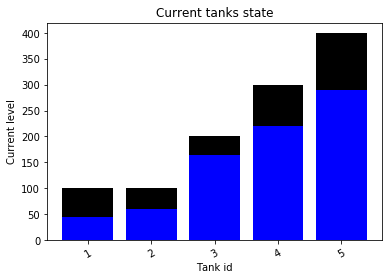

In [8]:
if train_epsilon == True:
    train_Q_epsilon()

### Testing

In [ ]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system()
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#Load trained Q-values
# if train == False:
#     simulation_id = 8
#     train_iterations = 20*10**5
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


# if retrain == False:
#     simulation_id = 7
#     train_iterations = 259*10**6
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

   
test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


test_iterations = 1000
test_freq = 1

test_visualization_steps = []
test_rewards_list = []

In [ ]:
def test_Q(test_iterations = test_iterations,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq
          ):
    
    for i in range(1,test_iterations+1):
        #print("state", test_toy_system.s, test_toy_system.ds)
        system.update_state()
        
        #Save visualization steps
        if i % freq == 0:
            visualization_steps.append(system.visualize());
    
        s0 = system.state_to_string()
        best_action = optimal_policy(s0, Q)
        #print("best_action", best_action)
        
        if best_action == None:
            reward = system.random_action()
            if i % freq == 0:
                print(i,reward, " Random action is performed. Current state unknown for Q.")

        else:
            reward = system.deterministic_action(best_action)
            if i % freq == 0:
                print(i,reward, best_action)
        
        system.reset_trucks_positions();
        system.reset_trucks_loads();
            
        #Save rewards
        if i % freq == 0:
            rewards_list.append(reward);


In [ ]:
test_Q()

In [ ]:
# Visualizing test simulation:
+47
test_anim = ut.create_system_animation(test_visualization_steps, test_iterations,test_freq)
HTML(test_anim.to_html5_video())
`ç+h gcfxzñ`´


In [ ]:
p = plt.plot([i for i in range(len(test_rewards_list))], test_rewards_list)
plt.show()

In [ ]:
# Visualizing train simulation:
train_anim = ut.create_system_animation(train_visualization_steps, train_iterations, train_freq)
HTML(train_anim.to_html5_video())

In [4]:
   # simulation_id = 4
    #train_iterations = 2*10**6
    #test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    #Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

len(list(Q))

NameError: name 'ut' is not defined